# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*



In [1]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

Connection successful!


# Setup parameters

In [2]:
# parameters for the Signal Generator
f_min           = 10e6                                  # tryout value
f_max           = 50e6                                  # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -25                                   # Set the amplitude of the signal in dBm
pulse_width     = 2                                     # 2 microsec
pulse_delay     = 0
pulse_period    = 400  


sGen.reset()
sGen.clear()
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = 250e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

# Acquisition of signals for each frequency in the range

In [10]:

slip = 0.0      # time of sleep of triggering

fetched_data = []

for i in pulse_freq:
    #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.01)
    # wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
    fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]

print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


Number of sweeps: 40 / 40


# Plot of a sweep with the peaks of amplitudes marked

In [4]:
def data_plot(y: np.array):
    x = np.arange(len(y))/pxie.sample_rate
    indices = find_peaks(y)
    plt.clf()
    plt.grid()
    plt.plot(x, y)
    idx = indices[0]
    plt.scatter(x[idx],y[idx], color = 'orange')
    plt.show()

freq: 38000000.0


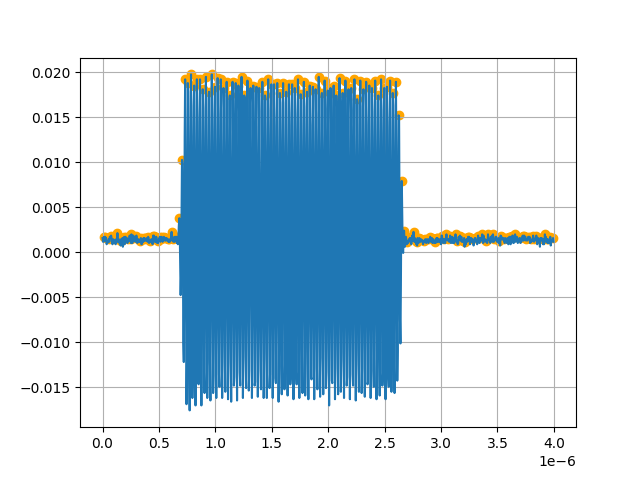

In [5]:
f_chosen = fetched_data[28]
print('freq:', f_chosen['freq'])
y = np.array(f_chosen['data'])

data_plot(y)

# Save data on HDF5 file

In [6]:
# with h5py.File('nonloso.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

In [7]:
# with h5py.File('nonloso.hdf5', 'r') as f:
#     for j in f:
#     # idx = 7
#     gp = f[str(idx)]
#     dic = {}
#     for i, k in gp.items():
#         dic[i] = k[()]
# freq = dic['freq']
# data = dic['data']

# data_plot(data)


# First Data Analysis tryout

In [8]:
offset = 2.5e-6
end = 5e-6

with h5py.File('nonloso.hdf5', 'r'):
    

SyntaxError: unexpected EOF while parsing (881495004.py, line 5)

In [ ]:
with h5py.File('nonloso.hdf5', 'r') as f:
    for j in range(len(f)):
        print(j)
    # idx = 7
        gp = f[str(j)]
        dic = {}
        for i, k in gp.items():
            dic[i] = k[()]
        freq = dic['freq']
        data = dic['data']

        data_plot(data)